# Tarea 5: Ajuste de hiperpaŕametros utilizando Tensorflow y Tensorboard (Puntos Extra)

## Procesamiento de los datos

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs_ep/ 

In [3]:
# librerias importantes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
import pickle
import time

from tensorboard.plugins.hparams import api as hp
np.random.seed(1)

%matplotlib inline

2023-04-23 16:41:03.996305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 16:41:04.183330: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 16:41:04.194797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-23 16:41:04.194816: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [4]:
# cargamos los datos
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

In [5]:
print('The shape of x_train is', x_train.shape)
print('The shape of y_train is', y_train.shape)

print('\nThe shape of x_test is', x_test.shape)
print('The shape of y_test is', y_test.shape)

The shape of x_train is (60000, 28, 28)
The shape of y_train is (60000,)

The shape of x_test is (10000, 28, 28)
The shape of y_test is (10000,)


In [6]:
# diccionario de etiquetas
dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
       5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [7]:
# normalizamos los datos
train_x = x_train/255
test_x = x_test/255

In [8]:
# one-hot encoding

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_y = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
test_y  = enc.transform(y_test.reshape(-1, 1)).toarray()

# Definicion de la arquitectura de la red neuronal

In [9]:
# celda 14 a modificar, hiperparametros
HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([128, 64]))
HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([32, 16]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.05, 0.10]))
HP_LEARNINGRATE= hp.HParam('learning_rate', hp.Discrete([0.1, 0.01, 0.001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs_ep/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_L1, HP_NUM_UNITS_L2, HP_DROPOUT, HP_LEARNINGRATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

2023-04-23 16:41:07.486727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-23 16:41:07.486765: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 16:41:07.486789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hinostra): /proc/driver/nvidia/version does not exist
2023-04-23 16:41:07.487150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def architecture(input_shape, num_classes, units_l1, units_l2, dropout=True, p_drop=0):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(p_drop)(x)  # yo tengo la ultima version de keras, en esta 'p' se reemplaza por 'rate'
    
    # 1st hidden layer
    x = Dense(units_l1, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    # 2nd hidden layer
    x = Dense(units_l2, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='FashionMNISTModel')

    return model

In [11]:
one_image = (28, 28, 1)
num_classes = 10


def train_test_model(hparams):

    model = architecture(input_shape=one_image, num_classes=num_classes, 
                         units_l1=hparams[HP_NUM_UNITS_L1], units_l2=hparams[HP_NUM_UNITS_L2],
                         p_drop=hparams[HP_DROPOUT])
    model.compile(
          optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
    model.optimizer.learning_rate=hparams[HP_LEARNINGRATE]
    model.fit(x_train, train_y, epochs = 10, batch_size = 32, \
                                validation_split = 0.1, shuffle=True, verbose=0)
    _, accuracy = model.evaluate(x = test_x, y = test_y)
    return accuracy

In [12]:
def training(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [13]:
from collections import OrderedDict, namedtuple
from itertools import product
session_num = 0

class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple('Run', params.keys())

        runs=[]

        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs
    
params=OrderedDict(
        num_units_l1=[num_units for num_units in HP_NUM_UNITS_L1.domain.values],
        num_units_l2=[num_units for num_units in HP_NUM_UNITS_L2.domain.values],
        p_drop=[dropout_rate for dropout_rate in (HP_DROPOUT.domain.values)],
        lr=[lr for lr in HP_LEARNINGRATE.domain.values],
    )

for run in RunBuilder().get_runs(params):
    hparams = {
          HP_NUM_UNITS_L1: run.num_units_l1,
          HP_NUM_UNITS_L2: run.num_units_l2,
          HP_DROPOUT: run.p_drop,
          HP_LEARNINGRATE: run.lr
      }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    training('logs_ep/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'num_units_l1': 64, 'num_units_l2': 16, 'dropout': 0.05, 'learning_rate': 0.001}
313/313 [==============================] - 0s 700us/step - loss: 0.6676 - accuracy: 0.7542
--- Starting trial: run-1
{'num_units_l1': 64, 'num_units_l2': 16, 'dropout': 0.05, 'learning_rate': 0.01}
313/313 [==============================] - 0s 731us/step - loss: 1.3627 - accuracy: 0.3772
--- Starting trial: run-2
{'num_units_l1': 64, 'num_units_l2': 16, 'dropout': 0.05, 'learning_rate': 0.1}
313/313 [==============================] - 0s 713us/step - loss: 2.3079 - accuracy: 0.1000
--- Starting trial: run-3
{'num_units_l1': 64, 'num_units_l2': 16, 'dropout': 0.1, 'learning_rate': 0.001}
313/313 [==============================] - 0s 687us/step - loss: 0.7254 - accuracy: 0.7188
--- Starting trial: run-4
{'num_units_l1': 64, 'num_units_l2': 16, 'dropout': 0.1, 'learning_rate': 0.01}
313/313 [==============================] - 0s 653us/step - loss: 1.5414 - accuracy: 0.3737
--- Startin

## Visualización de los resultados en Tensorboard

In [15]:
%tensorboard --logdir logs_ep/hparam_tuning

In [16]:
# no correr esta celda, es solo para que yo (Alejandra) pueda visualizar los datos
from pandas import read_csv
df_hpars = read_csv('./hparams_table_ep.csv')
print('Los tres mejores modelos')
df_hpars.nlargest(3, ['Accuracy'])

Los tres mejores modelos


,num_units_l1,num_units_l2,dropout,learning_rate,Accuracy
3,64.0,16.0,0.05,0.001,0.7542
22,64.0,32.0,0.10,0.001,0.7527
1,128.0,32.0,0.10,0.001,0.7526


In [17]:
# elegimos el mejor modelo
n_units_l1 = 64
n_units_l2 = 16
p_drop     = 0.05

def architecture(input_shape, num_classes, dropout=True):
    
    # Defining the input as a tensor with shape input_shape. 
    InputLayer = Input(input_shape)
    
    # Flattening the input tensor of dimensions (32, 32, 3) to a tensor of dimensions (3072)
    x = Flatten()(InputLayer)
    if dropout == True:
        x = Dropout(p_drop)(x)  # yo tengo la ultima version de keras, en esta 'p' se reemplaza por 'rate'
    
    # 1st hidden layer
    x = Dense(n_units_l1, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_1')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)

    # 2nd hidden layer
    x = Dense(n_units_l2, kernel_initializer='random_uniform', bias_initializer='zeros', name='hl_2')(x)
    x = Activation('sigmoid')(x)
    if dropout == True:
        x = Dropout(p_drop)(x)
    
    # For the output layer we use the activation function 'softmax')
    x = Dense(num_classes, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    OutputLayer = Activation('softmax', name='output-layer')(x)
    
    # This creates the Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = InputLayer, outputs = OutputLayer, name='FashionMNISTModel')

    return model

In [28]:
best_model = architecture((28,28,1), 10)

In [29]:
best_model.summary()

Model: "FashionMNISTModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 dropout_78 (Dropout)        (None, 784)               0         
                                                                 
 hl_1 (Dense)                (None, 64)                50240     
                                                                 
 activation_52 (Activation)  (None, 64)                0         
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
                                                                 
 hl_2 (Dense)                (None, 16)          

In [30]:
from keras.optimizers import Adam

learning_rate = 0.001
optimizer     = Adam(learning_rate=learning_rate)
loss_function   = 'categorical_crossentropy'
metric_function = 'accuracy'

In [31]:
best_model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

In [32]:
#10 % of the training data will be used to validate the training
start_time = time.time()

validation_portion = 0.1
batch_size = 32
num_epochs = 100

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="logs/best_model", histogram_freq=1)

history = best_model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[tensorboard_callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/100
1688/1688 [==============================] - 4s 2ms/step - loss: 1.5556 - accuracy: 0.3486 - val_loss: 1.2433 - val_accuracy: 0.4615
Epoch 2/100
1688/1688 [==============================] - 4s 2ms/step - loss: 1.1907 - accuracy: 0.4794 - val_loss: 1.0802 - val_accuracy: 0.5623
Epoch 3/100
1688/1688 [==============================] - 3s 2ms/step - loss: 1.0410 - accuracy: 0.5745 - val_loss: 0.9213 - val_accuracy: 0.6240
Epoch 4/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.9558 - accuracy: 0.6120 - val_loss: 0.8595 - val_accuracy: 0.6405
Epoch 5/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.9156 - accuracy: 0.6360 - val_loss: 0.7928 - val_accuracy: 0.6933
Epoch 6/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.8791 - accuracy: 0.6503 - val_loss: 0.7979 - val_accuracy: 0.6862
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8295 - accuracy: 0.6749 - val_loss: 0.7423 - val_ac

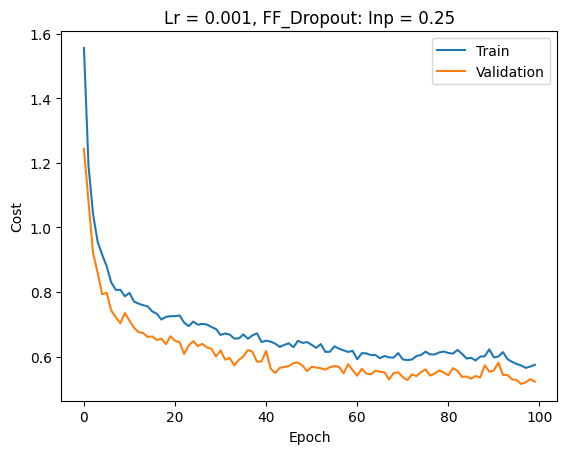

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Lr = 0.001, FF_Dropout: Inp = 0.25')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

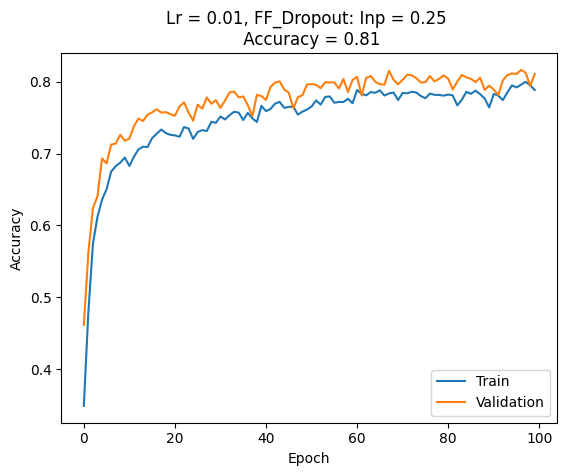

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Lr = 0.01, FF_Dropout: Inp = 0.25 \n Accuracy = 0.81')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [36]:
# Evaluamos el modelo
evaluations = best_model.evaluate(x=test_x, y=test_y)
print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

313/313 [==============================] - 0s 755us/step - loss: 0.5321 - accuracy: 0.8087
Loss = 0.5320552587509155
Test Accuracy = 0.8087000250816345
